## Clean data set

In [353]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

---

#### Gộp dữ liệu năm 21,22,23 lại thành 1 DataFrame

In [354]:
uni_21 = pd.read_csv('../data/raw/raw_benchmark_scores_hcm_2021.csv')
uni_22 = pd.read_csv('../data/raw/raw_benchmark_scores_hcm_2022.csv')
uni_23 = pd.read_csv('../data/raw/raw_benchmark_scores_hcm_2023.csv')

In [355]:
# Thêm vào các năm tương ứng với từng dataset
uni_21['year_'] = 2021
uni_22['year_'] = 2022
uni_23['year_'] = 2023

In [356]:
# Ghép các dataframe lại với nhau
df = pd.concat([uni_21,uni_22,uni_23],ignore_index=True)

In [357]:
df = df[['year_','university_code','specialized_major','major_code','major_name','subject_group_code','note','benchmark_score']]

In [358]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6759 entries, 0 to 6758
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year_               6759 non-null   int64  
 1   university_code     6759 non-null   object 
 2   specialized_major   2227 non-null   object 
 3   major_code          6759 non-null   object 
 4   major_name          6759 non-null   object 
 5   subject_group_code  6759 non-null   object 
 6   note                5888 non-null   object 
 7   benchmark_score     6759 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 422.6+ KB


---

#### Tổng quan về dữ liệu

- Bảng chứa thông tin chuyển sinh các trường đại học tại TP. HCM với nhiều chuyên ngành khác nhau.
- Mỗi hàng tương ứng với các ngành đào tạo, điểm chuẩn và phương thức xét tuyển.
- Các cột chính trong bảng:
    - `year_`: Năm xét tuyển
    - `university_code`: Mã trường
    - `specialized_major`: Chuyên ngành
    - `major_name`: Ngành
    - `major_code`: Mã ngành (Mỗi trường thường sẽ có mã ngành khác nhau cho từng ngành học)
    - `subject_group_code`: Mã tổ hợp môn thi
    - `benchmark_score`: Điểm chuẩn trúng tuyển vào ngành (có nhiều thanh điểm)
    - `note`: Phương thức xét tuyển

---

#### Xác định vấn đề cần giải quyết

- Thêm hệ đào tạo
- Xử lý phương thức thi `note`
    + Tốt nghiệp THPT
    + Đánh giá năng lực Đại học Quốc gia TPHCM (`subject_group_code` == DGNL và `note`)
    + Xét học bạ (dựa vào `subject_group_code` == XDHB và `note`)

- Xử lý điểm `benchmark_score`
    + Học bạ và Tốt nghiệp THPT between 1 và 30
    + Đánh giá năng lực Đại học Quốc gia TPHCM between 550 và 1200

- Xử lý tổ hợp môn thi `subject_group_code`
    + Chuẩn hoá dữ liệu, ô chứa đa trị -> chứa 1 dữ liệu duy nhất

- Drop duplicated, missing data, ...
- Thêm mã ngành theo đúng quy chuẩn của bộ

---

#### Bước 1: thêm hệ đào tạo

In [359]:
df['note'] = df['note'].str.lower()

In [360]:
df['note'].value_counts().to_frame()

,count
note,
điểm thi tn thpt,1002
tốt nghiệp thpt,748
học bạ,561
đánh giá năng lực đại học quốc gia tphcm,328
xét học bạ,303
...,...
tốt nghiệp thpt; hệ thống nhúng và iot,1
chuyên ngành thiết kế vi mạch; đánh giá năng lực đại học quốc gia tphcm,1
chuyên ngành hệ thống nhúng và iot; đánh giá năng lực đại học quốc gia tphcm,1


In [361]:
criterion_lst = [
    'chất lượng cao',
    'clc',
    'ctlk',
    'chương trình tiên tiến',
    'chương trình tài năng',
    'chương trình quốc tế',
    'chương trình liên kết quốc tế',
    'chất lượng cao tiếng anh',
    'clc tiếng anh',
    'clc tiếng việt',
    'chất lượng cao tiếng việt',
    'chất lượng cao định hướng nhật',
    'chất lượng cao việt nhật',
    'chương trình việt-pháp',
    'chương trình đại học chính quy quốc tế cấp song bằng',
    'chương trình đại học chính quy quốc tế song bằng',
    'ct liên kết quốc tế 2+2'
]

In [362]:
df['program_type'] = df['note'].str.contains('|'.join(criterion_lst), case=False, na=False).map({True: 'CLC', False: 'DT'})

---

#### Bước 2: Xử lý phương thức xét tuyển

Dựa vào `note` để phân loại chính nó, các phương thức xét tuyển

In [363]:
# Lọc các phương thức có 'thpt' -> Tốt nghiệp THPT 
mask_thpt = df['note'].str.contains('thpt',na=False)
df.loc[mask_thpt,'note'] = 'Tốt nghiệp THPT'

# Lọc các phương thức có 'học bạ' -> Xét học bạ
mask_hocBa = df['note'].str.contains('học bạ',na=False)
df.loc[mask_hocBa,'note'] = 'Xét học bạ'

# Lọc các phương thức có 'đánh giá' -> Đánh giá năng lực ĐHQG-HCM
mask_danhGiaNangLuc = df['note'].str.contains('đánh giá',na=False)
df.loc[mask_danhGiaNangLuc,'note'] = 'Đánh giá năng lực ĐHQG-HCM'

Dựa vào `subject_group_code` để phân loại các phương thức xét tuyển

In [364]:
df.loc[:,'subject_group_code'].value_counts().to_frame()

,count
subject_group_code,
DGNLHCM,1162
"A00, A01, D01, D07",383
"A00, A01",236
"A00, A01, D01",231
A00,192
...,...
"B00, B08",1
D15,1
"B08, A01, D01, B04, D03",1


In [365]:
# Trong tổ hợp có 2 cách viết đánh giá năng lực -> chuyển về thành 1 'DGNL'. Nhất quán về dữ liệu
df.loc[:,'subject_group_code']=df.loc[:,'subject_group_code'].str.replace('DGNLHCM','DGNL')

In [366]:
# subject_group_code == XDHB -> Xét học bạ
df.loc[df['subject_group_code'].str.contains('XDHB', na=False), 'note'] = 'Xét học bạ'

# subject_group_code == DGNL -> Đánh giá năng lực ĐHQG-HCM
df.loc[df['subject_group_code'].str.contains('DGNL', na=False), 'note'] = 'Đánh giá năng lực ĐHQG-HCM'

Tập trung dữ liệu vào 3 phương thức xét tuyển chính

In [367]:
lst_admission_method = ['Tốt nghiệp THPT','Xét học bạ','Đánh giá năng lực ĐHQG-HCM']

correct_method = df['note'].isin(lst_admission_method)

# Chuyển các phương thức không nằm trong danh sách trên về None
df.loc[~correct_method,'note'] = None

In [368]:
df['note'].value_counts()

note
Tốt nghiệp THPT               3203
Xét học bạ                    1762
Đánh giá năng lực ĐHQG-HCM    1371
Name: count, dtype: int64

---

#### Bước 3: Xử lý điểm chuẩn

In [369]:
method_exam = df['note']
score = df['benchmark_score']

In [370]:
# Điều kiện điểm chuẩn phù hợp của Thi THPT
cond_1 = ((method_exam == 'Xét học bạ') | (method_exam == 'Tốt nghiệp THPT')) & ((score > 0.0) & (score <= 30.0))

# Điều kiện điểm chuẩn phù hợp của thi DGNLHCM
cond_2 = ((method_exam == 'Đánh giá năng lực ĐHQG-HCM') & ((score >= 550.0) & (score <= 1200.0)))

# Điều kiện điểm chuẩn không hợp lệ của phương thức khác, đang ở thang điểm 10
cond_3 =(( method_exam == 'Tốt nghiệp THPT') | (method_exam == 'Xét học bạ')) & (score < 10.0)

# Kết hợp 2 điều kiện cho 2 phương thức khác nhau
valid_cond = cond_1 | cond_2

In [371]:
# Gán None cho các dữ liệu không đạt
df.loc[~valid_cond,'benchmark_score'] = None

In [372]:
df.loc[cond_3, 'benchmark_score'] = df.loc[cond_3, 'benchmark_score'] * 3.0

---

#### Bước 4: Xử lý, chuẩn hoá tổ hợp môn thi

Xử lý các dòng chứa đa trị

In [373]:
df['subject_group_code'] = df['subject_group_code'].str.replace(' ','') # bỏ đi các ký tự khoảng trắng
df['subject_group_code'] = df['subject_group_code'].str.split(',')      # chia các giá trị ra thành list, cắt theo ','
df = df.explode('subject_group_code').reset_index(drop=True)           

Cập nhật lại phương thức đúng sau khi split và trước đó dùng contains để xác định cho `note`

In [374]:
# Các bổ hợp có dạng vd: 'A00,A01, ...'|'DD2' -> đưa về thành phương thức THPT
df.loc[df['subject_group_code'].str.contains(r"^[A-Z][0-9]{2}$|^[A-Z]{2}[0-9]", na=False),'note'] = 'Tốt nghiệp THPT'

In [375]:
df['note'].value_counts()

note
Tốt nghiệp THPT               16933
Xét học bạ                     1689
Đánh giá năng lực ĐHQG-HCM     1391
Name: count, dtype: int64

---

#### Bước 5: Các bước làm sạch dữ liệu khác

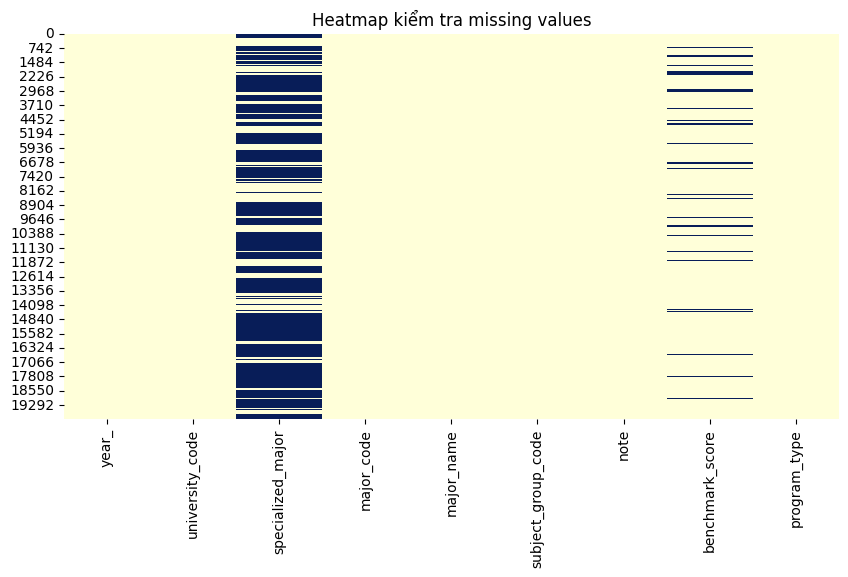

In [376]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cbar=False, cmap='YlGnBu') 
plt.title('Heatmap kiểm tra missing values')
plt.show()

Xoá None data, duplicated

In [377]:
# Chuyên ngành thiếu quá nhiều dữ liệu
print(f"Phần trăm dữ liệu bị thiếu {round(df['specialized_major'].isnull().sum() / df.shape[0] * 100,3)}% ")
df.drop(columns=['specialized_major'], inplace=True)
print("Đã xóa chuyên ngành vì thiếu quá nhiều dữ liệu")

# Xoá dữ liệu None
df.dropna(subset=['benchmark_score'], inplace=True) # Xoá các dòng mà benchmark_score == None
print("Đã xóa dữ liệu None")

# Xoá các dòng trùng lập
df.drop_duplicates(inplace=True)# Xoá các dòng trùng lập
print("Đã xóa các dòng trùng lập")
df.reset_index(drop=True, inplace=True) # reset lại index

Phần trăm dữ liệu bị thiếu 68.031% 
Đã xóa chuyên ngành vì thiếu quá nhiều dữ liệu
Đã xóa dữ liệu None
Đã xóa các dòng trùng lập


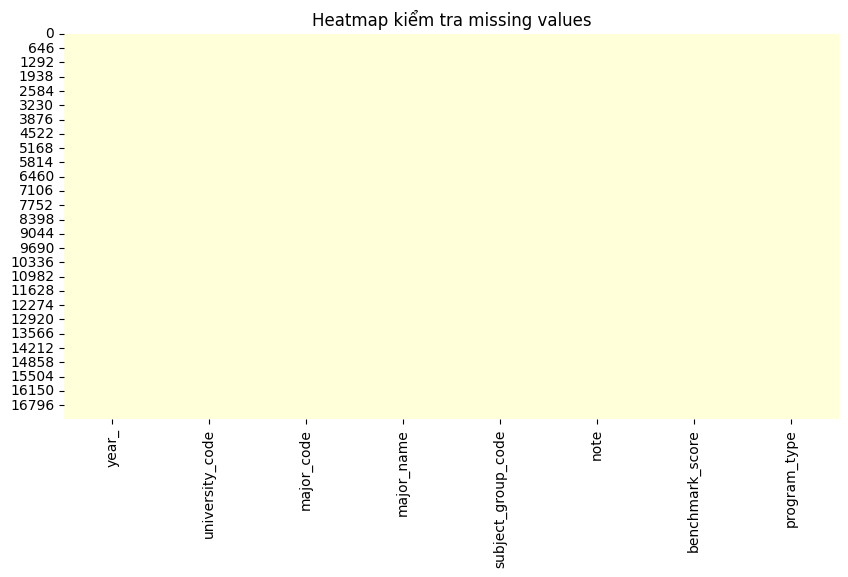

In [378]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cbar=False, cmap='YlGnBu')
plt.title('Heatmap kiểm tra missing values')
plt.show()

Chuẩn hóa các cột `major_name` và `university_code`

In [379]:
# Loại bỏ khoảng trắng thừa và chuẩn hóa chữ thường
df['major_name'] = df['major_name'].str.replace(r'\s+,', ',', regex=True).str.strip()
df['university_code'] = df['university_code'].str.strip().str.upper()

Thêm cột thang điểm để rõ ràng hơn `score_scale`

In [380]:
score_scale = {
    'Tốt nghiệp THPT': 30,
    'Xét học bạ': 30,
    'Đánh giá năng lực ĐHQG-HCM': 1200
}

 # Thêm cột điểm chuẩn tương ứng với từng phương thức
df['score_scale'] = df['note'].map(score_scale)

##### Phân tích dữ liệu trước khi cân bằng

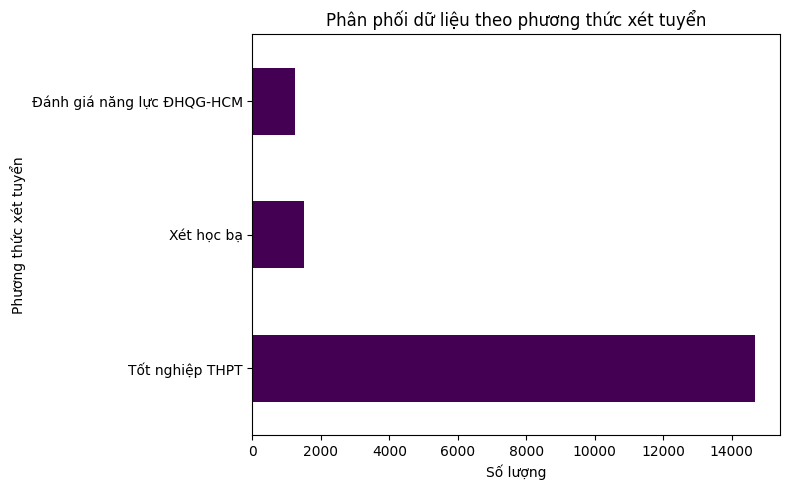

In [381]:
# Biểu đồ ngang phân phối dữ liệu theo 'note'
df['note'].value_counts().plot(
    kind='barh',
    figsize=(8, 5),
    title='Phân phối dữ liệu theo phương thức xét tuyển',
    colormap='viridis' 
)
plt.xlabel('Số lượng')
plt.ylabel('Phương thức xét tuyển')
plt.tight_layout()
plt.show()


---

#### Bước 6: Cân bằng dữ liệu

In [382]:
# Số dòng bạn muốn lấy từ nhóm 'Tốt nghiệp THPT', ví dụ bằng số dòng nhóm lớn nhất
target_n = max(
    df['note'].value_counts()['Xét học bạ'],
    df['note'].value_counts()['Đánh giá năng lực ĐHQG-HCM']
)

# 1. Lấy random N dòng từ nhóm 'Tốt nghiệp THPT'
df_thpt_sampled = df[df['note'] == 'Tốt nghiệp THPT'].sample(n=target_n, random_state=42)

# 2. Lấy toàn bộ các nhóm còn lại
df_others = df[df['note'] != 'Tốt nghiệp THPT']

# 3. Ghép lại thành dataset đã được cân bằng
df_balanced = pd.concat([df_thpt_sampled, df_others], ignore_index=True)

# 4. Shuffle cho ngẫu nhiên
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

#Kiểm tra lại phân phối
print(df_balanced['note'].value_counts())


note
Tốt nghiệp THPT               1510
Xét học bạ                    1510
Đánh giá năng lực ĐHQG-HCM    1232
Name: count, dtype: int64


Vẽ boxplot

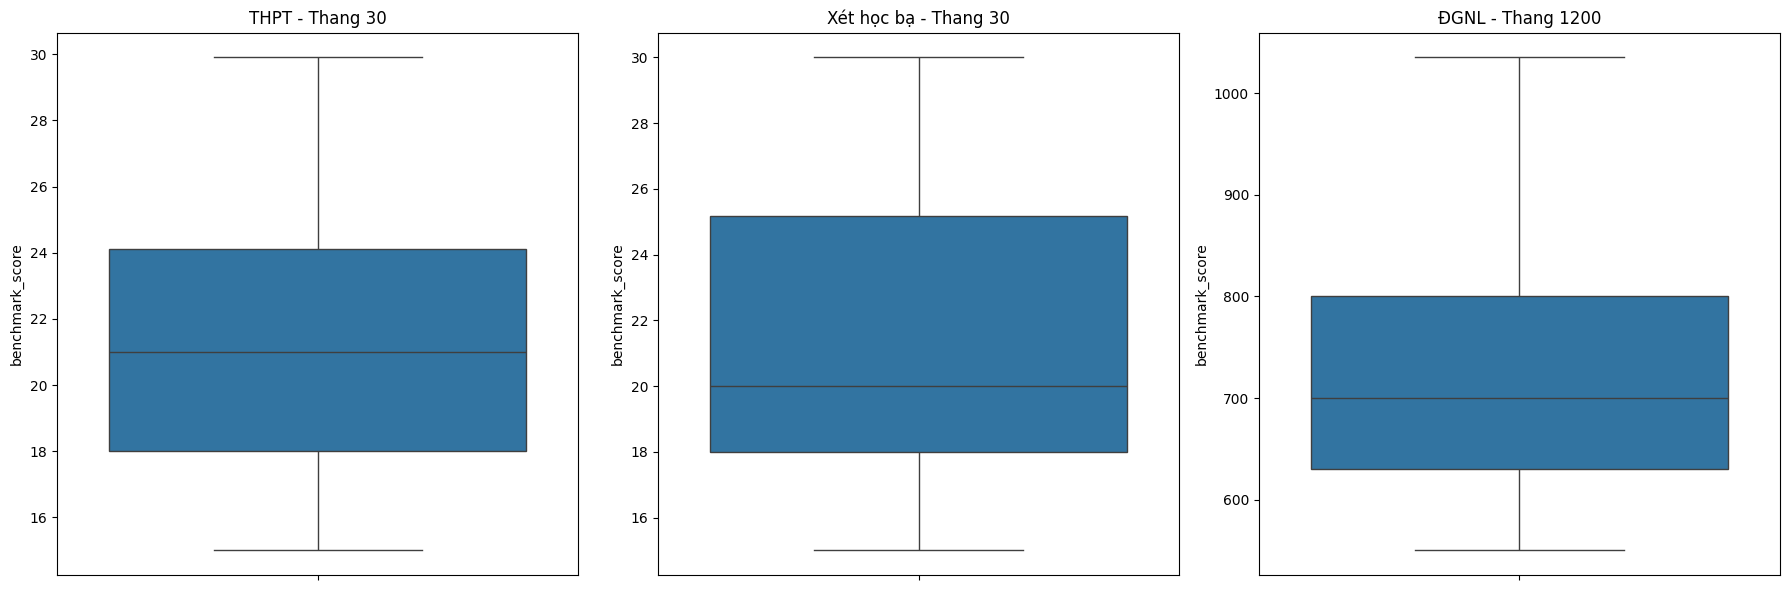

In [383]:
# Tạo 3 dataframe riêng
df_thpt = df_balanced[df_balanced['note'] == "Tốt nghiệp THPT"]
df_hocba = df_balanced[df_balanced['note'] == "Xét học bạ"]
df_dgnl = df_balanced[df_balanced['note'] == "Đánh giá năng lực ĐHQG-HCM"]


# Vẽ từng biểu đồ riêng
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(data=df_thpt, y='benchmark_score', ax=axs[0])
axs[0].set_title('THPT - Thang 30')

sns.boxplot(data=df_hocba, y='benchmark_score', ax=axs[1])
axs[1].set_title('Xét học bạ - Thang 30')

sns.boxplot(data=df_dgnl, y='benchmark_score', ax=axs[2])
axs[2].set_title('ĐGNL - Thang 1200')

plt.tight_layout()
plt.show()

In [384]:
# sắp xếp lại theo thứ tự
df_balanced.sort_values(by=['year_','university_code','major_code','subject_group_code'], inplace=True)

# reset lại index
df_balanced.reset_index(drop=True, inplace=True) 

rename: `note` -> `admission_method`, `year_` -> `year`

In [385]:
df_balanced.rename(columns={'note':'admission_method','year_':'year','major_code':'uni_major_code'}, inplace=True)

In [386]:
df_balanced = df_balanced[['year','university_code','program_type','uni_major_code','major_name','subject_group_code','admission_method','score_scale','benchmark_score']]

---

#### Bước 7: Thêm cột `major_code` theo bộ đã đề ra

In [387]:
majors = pd.read_csv('../data/processed/majors.csv')

# join lại theo tên ngành
df = pd.merge(df_balanced,majors,on='major_name',how='inner')

In [388]:
df = df[['year','university_code','program_type','uni_major_code','major_code','major_name','subject_group_code','admission_method','score_scale','benchmark_score']]
df.sort_values(by=['year','university_code','program_type'], inplace=True)

In [389]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4462 entries, 0 to 4460
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                4462 non-null   int64  
 1   university_code     4462 non-null   object 
 2   program_type        4462 non-null   object 
 3   uni_major_code      4462 non-null   object 
 4   major_code          4462 non-null   int64  
 5   major_name          4462 non-null   object 
 6   subject_group_code  4462 non-null   object 
 7   admission_method    4462 non-null   object 
 8   score_scale         4462 non-null   int64  
 9   benchmark_score     4462 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 383.5+ KB


xuất ra file csv để tiếp tục trực quan và nghiên cứu ML

In [ ]:
# df.to_csv('benchmark_scores_2021_2023_cleaned.csv', index=False)